In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from utils import display_matrix
from debug import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 2
lambda_ = 0.99995
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.3, 0.15]), 'fb': np.array([0.15, 0.1])}

neural_lr_start = 0.1
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 20
hopfield_g = 0.05

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
# neurons[0].shape

In [6]:
# def append_ones_row_vector_to_tensor(inp_vector):
#     return torch.cat((inp_vector, torch.ones(1, inp_vector.shape[1]).to(inp_vector.device)), 0)

In [7]:
# x, y = next(iter(train_loader))
# x, y = x.to(device), y.to(device)
# x = x.view(x.size(0),-1).T
# y_one_hot = F.one_hot(y, 10).to(device).T
# print(model.B[0]['weight'][:-1].shape)
# neurons = model.init_neurons(x.size(1), device = model.device)

# torch.cat((neurons[0], torch.ones(1, neurons[0].shape[1]).to(device)), 0).shape
# append_ones_row_vector_to_tensor(neurons[0]).shape

In [8]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.12496666666666667


In [9]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 20

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        
        take_debug_logs_ = (idx % 500 == 0)
        if True:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, take_debug_logs_)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:11, 41.96it/s]
2it [00:00, 16.98it/s]

Epoch : 1, Train Accuracy : 0.9093666666666667, Test Accuracy : 0.9097


3000it [01:12, 41.60it/s]
4it [00:00, 39.92it/s]

Epoch : 2, Train Accuracy : 0.9335333333333333, Test Accuracy : 0.934


3000it [01:10, 42.75it/s]
4it [00:00, 39.39it/s]

Epoch : 3, Train Accuracy : 0.9445666666666667, Test Accuracy : 0.9428


3000it [01:11, 41.78it/s]
4it [00:00, 38.74it/s]

Epoch : 4, Train Accuracy : 0.9538666666666666, Test Accuracy : 0.9508


3000it [01:12, 41.54it/s]
5it [00:00, 40.43it/s]

Epoch : 5, Train Accuracy : 0.9589, Test Accuracy : 0.9548


3000it [01:11, 42.12it/s]
5it [00:00, 40.60it/s]

Epoch : 6, Train Accuracy : 0.9620833333333333, Test Accuracy : 0.9574


3000it [01:11, 42.14it/s]
5it [00:00, 41.45it/s]

Epoch : 7, Train Accuracy : 0.9662, Test Accuracy : 0.9606


3000it [01:12, 41.36it/s]
5it [00:00, 41.80it/s]

Epoch : 8, Train Accuracy : 0.9680666666666666, Test Accuracy : 0.9619


3000it [01:12, 41.59it/s]
5it [00:00, 41.90it/s]

Epoch : 9, Train Accuracy : 0.97105, Test Accuracy : 0.9651


3000it [01:10, 42.37it/s]
5it [00:00, 41.54it/s]

Epoch : 10, Train Accuracy : 0.9723333333333334, Test Accuracy : 0.9654


3000it [01:12, 41.54it/s]
5it [00:00, 41.58it/s]

Epoch : 11, Train Accuracy : 0.9739333333333333, Test Accuracy : 0.9683


3000it [01:12, 41.32it/s]
5it [00:00, 42.24it/s]

Epoch : 12, Train Accuracy : 0.9753333333333334, Test Accuracy : 0.9675


3000it [01:11, 42.14it/s]
5it [00:00, 40.98it/s]

Epoch : 13, Train Accuracy : 0.9758333333333333, Test Accuracy : 0.9678


3000it [01:10, 42.60it/s]
5it [00:00, 40.74it/s]

Epoch : 14, Train Accuracy : 0.9761833333333333, Test Accuracy : 0.9675


2068it [00:49, 41.64it/s]


KeyboardInterrupt: 

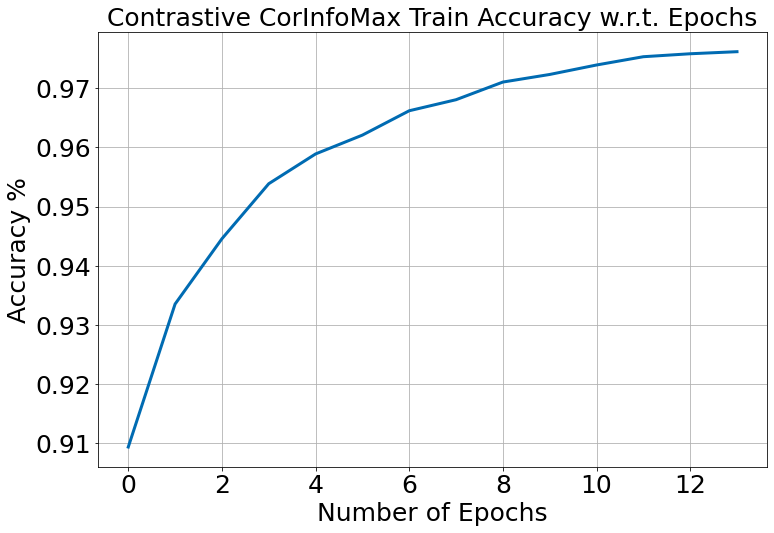

In [10]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

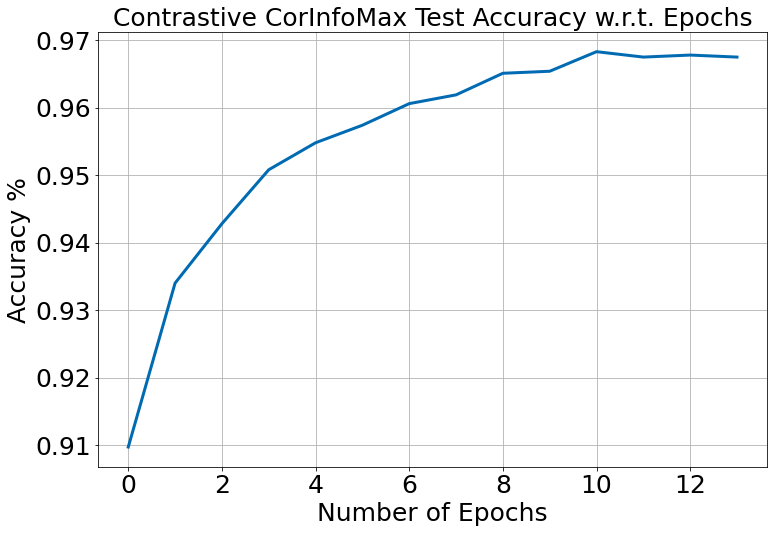

In [11]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

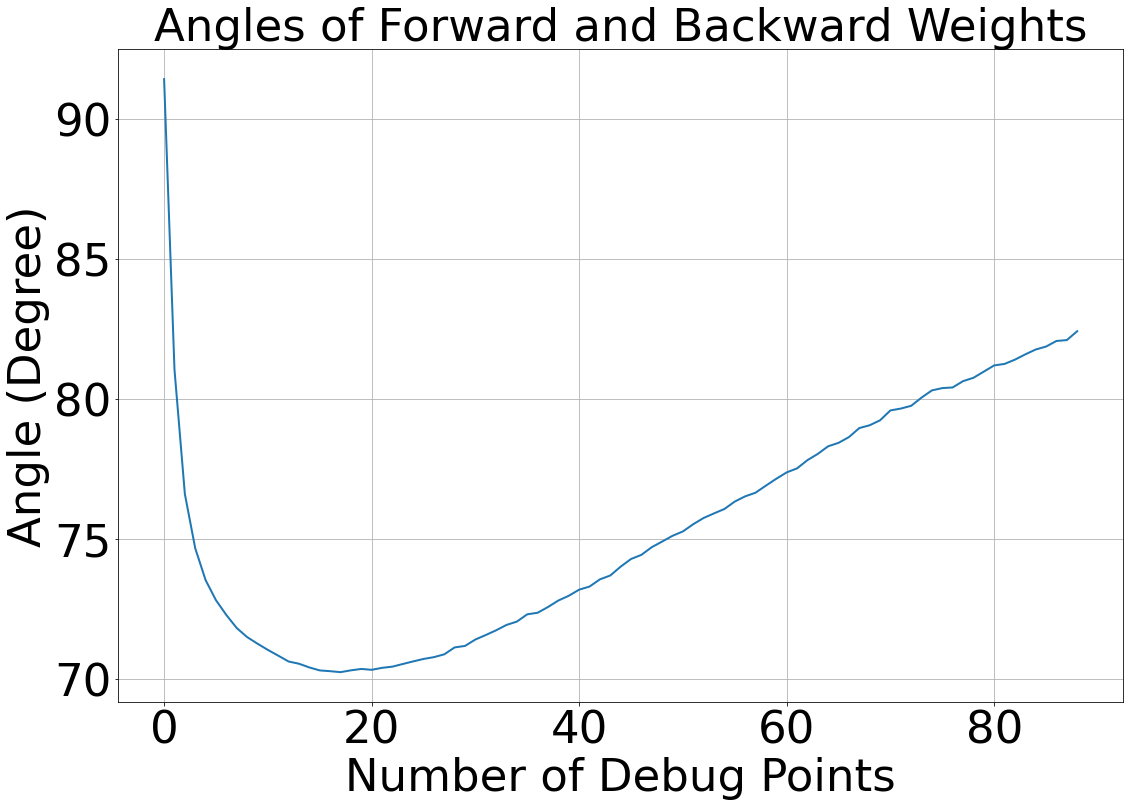

In [12]:
plt.figure(figsize = (18, 12))
plt.plot(model.forward_backward_angles, linewidth=2)
plt.xlabel("Number of Debug Points", fontsize=45)
plt.ylabel("Angle (Degree)", fontsize=45)
plt.title("Angles of Forward and Backward Weights", fontsize=45)
plt.grid()
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.show()

In [ ]:
display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
display_matrix(torch.linalg.inv(model.R[0]['weight'])[:10,:10])

In [ ]:
# from torch_utils import *

In [ ]:
# def angle_between_two_matrices(A, B):
#     """Computes the angle between two matrices A and B.

#     Args:
#         A (torch.Tensor): Pytorch tensor of size m times n
#         B (torch.Tensor): Pytorch tensor of size m times n

#     Returns:
#         angle: angle between the matrices A and B. The formula is given by the following:
#                (180/pi) * acos[ Tr(A @ B.T) / sqrt(Tr(A @ A.T) * Tr(B @ B.T))] 
#     """

#     angle = (180 / torch.pi) * torch.acos(torch.trace(A @ B.T) / torch.sqrt(torch.trace(A @ A.T) * torch.trace(B @ B.T)))
#     return angle

In [ ]:
plt.plot(model.forward_backward_angles)

In [ ]:
angle_between_two_matrices(model.Wff[1]['weight'], model.Wfb[1]['weight'].T).item()

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])